## ASSIGNMENT-2

TEAM-NAME: AS-MR with Keshav

IDs: 2021101016, 2021101018, 2021101094

NAMEs: Shreyas Reddy Palley, Keshav Gupta, Akshat Sanghvi

### Instructions
 * Fill in the team name, id and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit this notebook in the GitHub Classroom repo and any other results files under the result folder. 
 * Commits past the deadline will not be considered.
 * Extensions will be granted using the extension policy only, so please go through the policy carefully and reach out to the TAs beforehand.

In [1]:
# List the imports here

import numpy as np
import open3d as o3d
from matplotlib import pyplot as plt

### SECTION 1: Non-Linear least squares optimization for Gaussian function

### 1.1 Levenberg Marquardt

Implement the Levenberg Marquardt algorithm from scratch using numpy to solve for the parameters of a gaussian distribution.

A Gaussian distribution parametrized by $a,m,s$ is given by:

$$ y(x;a,m,s)=a \exp \left(\frac{-(x-m)^{2}}{2 s^{2}}\right) \tag{1}$$

##### Problem to solve

> Given a set of observations $y_{obs}$ and $x_{obs}$ we want to find the optimum parameters $a,m,s$ which best fit our observations given an initial estimate.

* Experiment with the number of iterations.
* Experiment with the learning rate.
* Experiment with the tolerance.

Display your results using matplotlib by plotting graphs for 
* The cost function value ($\|r\|^2$) vs the number of iterations
* The Ground Truth data values and the predicted data values.

Experiment with the hyperparameters and compile your observations in a table. Clearly mention your hyperparameters with justification.

You can refer to [Shubodh's notes](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02) on the same to get a better grasp of the concept before implementing it.

In [2]:
##############################################################################
# TODO: Do tasks described in 1.1 (a)
##############################################################################

##### Function and Gradient

In [3]:
def f(x, params):
    a, m, s = params
    exp = -1 * (np.square(x - m) / (2 * np.square(s)))
    y = a * np.exp(exp)
    return y

def grad(x, params):
    a, m, s = params
    exp = -1 * (np.square(x - m) / (2 * np.square(s)))
    y = np.exp(exp)                                 # dfda
    t2 = ((a * (x-m)) / np.square(s)) * y           # dfdm
    t3 = (a * np.square(x - m) / (s**3)) * y        # dfds
    return np.array([y, t2, t3])


In [4]:

def generateData(f, a=1, m=1, s=1):
    # x = np.random.randn(1000)
    x = np.random.rand(1000) * 2
    y = f(x, [a, m, s])
    
    return x, y
    
x, y = generateData(f)
# plt.scatter(x, y)
# plt.show()

#### Others

##### Gradient Descent

In [495]:
def gradientDescent(x, y, iterations=3, alpha=0.1):
    params = np.random.randn(3)      # a, m, s
    # params = np.array([0.21, 0.2, 1.1])
    param2 = []
    
    for i in range(iterations):
        fx = f(x, params)
        diff = -2 * (y - fx)
        
        jacobian = np.array(grad(x, params))
        # print(jacobian.shape, diff.shape)
        jd = np.matmul(jacobian, diff)
        jda = jd * alpha / x.shape[0]
        
        # print(jda)
        param2.append(params)
        # print(params)
        params -= jda

    param2 = np.array(param2)
    # print("p2", param2[:,0])
    # plt.plot(param2[:, 0])
    # plt.show()
    return params
    

In [505]:
x, y = generateData(f, 5, 0.2, 2)
# print(x, y)

params = gradientDescent(x, y, iterations=10000, alpha=0.1)
print(params)

[-0.45008726 -0.48088329  0.00338399]


##### Gauss Newton

In [527]:
def gn(x, y, iterations=3, alpha=0.1):
    params = np.random.rand(3) * 10      # a, m, s
    # params = np.random.randn(3)      # a, m, s
    # params = np.array([4.1, 0.2, 1.1])
        
    print("Initial Guess", params)
            
    for i in range(iterations):
        fx = f(x, params)
        diff = -2 * (y - fx)
                
        jacobian = np.array(grad(x, params))
        # print(jacobian.shape, diff.shape)
        jd = np.matmul(jacobian, diff)
        jda = jd * alpha / x.shape[0]
            
        inv = np.linalg.inv(np.matmul(jacobian, jacobian.T))
        jda2 = np.matmul(inv, jda)
        # print(jda2.shape)
                

        params -= jda2
    # print("p2", param2[:,0])
    # plt.plot(param2[:, 0])
    # plt.show()
    return params
        

In [528]:
x, y = generateData(f, 5, 0.2, 2)
# print(x, y)

params = gn(x, y, iterations=20000, alpha=0.1)
print(params)

Initial Guess [5.91884459 2.48932442 6.50760373]
[5.0104608  0.20170812 2.02712997]


#### LM

In [270]:

def lm(x, y, iterations=3, lambda1=1, lr=1, tolerance=1e-5):
    params = np.random.rand(3)      # a, m, s
    params = np.random.randn(3)      # a, m, s
    # params = np.array([4.1, 0.2, 1.1])
    
    # print("Initial Guess", params)
    paramsArray = []
    p = 0
    losses = []
            
    for i in range(iterations):
        fx = f(x, params)
        diff = -2 * (y - fx)
        
                
        jacobian = np.array(grad(x, params))
        # print(jacobian.shape, diff.shape)
        jd = np.matmul(jacobian, diff)
        jda = jd / x.shape[0]
            
        inv = np.linalg.inv(np.matmul(jacobian, jacobian.T) + lambda1 * np.eye(3, 3))
        jda2 = np.matmul(inv, jda)
        
        oldParams = np.copy(params)
        params -= lr * jda2          # params update
        
        fx2 = f(x, params)
        diff2 = -2 *(y - fx2)
        
        norm1 = np.linalg.norm(diff)
        norm2 = np.linalg.norm(diff2)
        # print("norms", norm1, norm2)
        if (norm1 >= norm2):
            loss = np.linalg.norm(y - fx2)
            lambda1 = 0.5 * lambda1
            p+=1
        else:
            params = np.copy(oldParams)
            loss = np.linalg.norm(y - fx)
            lambda1 = 2 * lambda1
            
        losses.append(loss)
        paramsArray.append(np.copy(params))
        
        if (np.linalg.norm(params - oldParams) < tolerance):
            break
        
    # print("p2", param2[:,0])
    paramsArray = np.array(paramsArray)

    losses = np.array(losses)
    return params, paramsArray, losses
        

In [271]:
a = 5
m = 0.2
s = 2
x, y = generateData(f, a, m, s)
# print(x, y)

params, paramsArray, losses = lm(x, y, iterations=2000, lambda1=1, lr=5)

#### A, M, S convergence

[4.99901075 0.1999895  2.00000606]


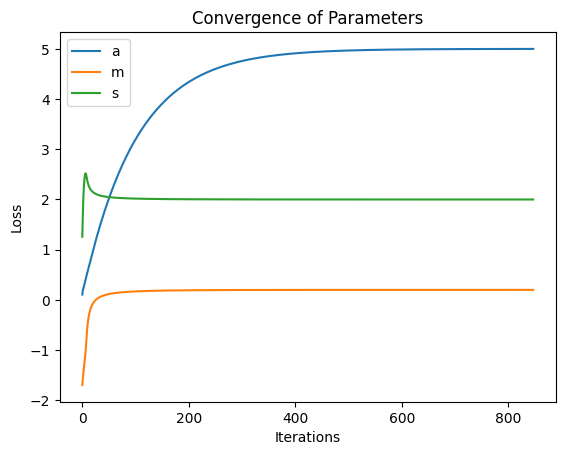

In [272]:
print(params)


plt.plot(paramsArray[:,0], label="a")
plt.plot(paramsArray[:,1], label="m")
plt.plot(paramsArray[:,2], label="s")
plt.title("Convergence of Parameters")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Number of Iterations Plot

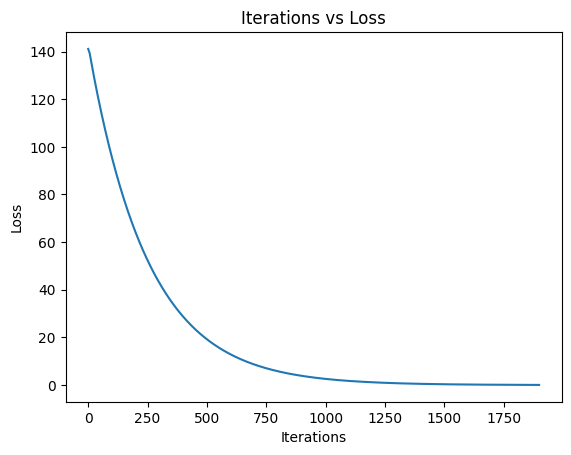

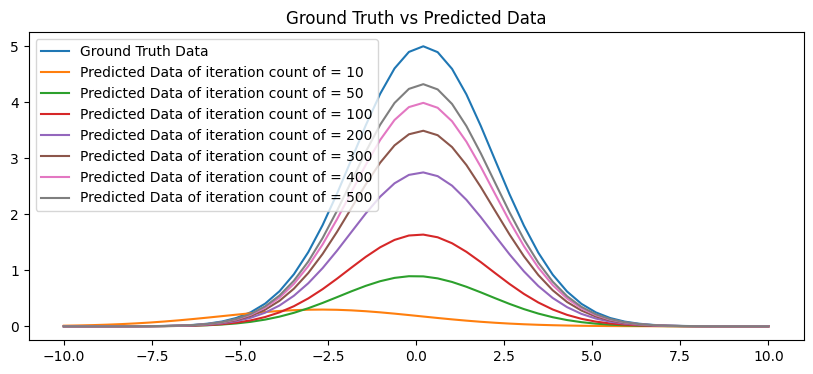

In [318]:
params, paramsArray1, losses = lm(x, y, iterations=2000, lambda1=1, lr=2)

plt.title("Iterations vs Loss")
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

its = [10, 50, 100, 200, 300, 400, 500]

x1 = np.linspace(-10, 10)


plt.figure(figsize=(10, 4))
plt.title("Ground Truth vs Predicted Data")
plt.plot(x1, f(x1, (a, m, s)), label="Ground Truth Data")

for i in range(len(its)):
    params1 = paramsArray1[its[i]]
    plt.plot(x1, f(x1, params1), label="Predicted Data of iteration count of = " + str(its[i]))

plt.legend()
plt.show()


#### Learning Rate Plot

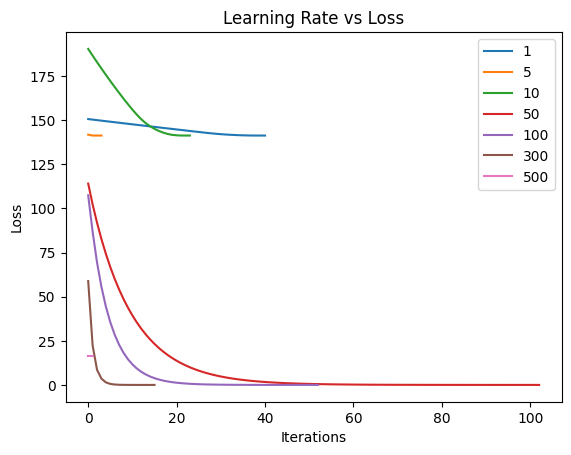

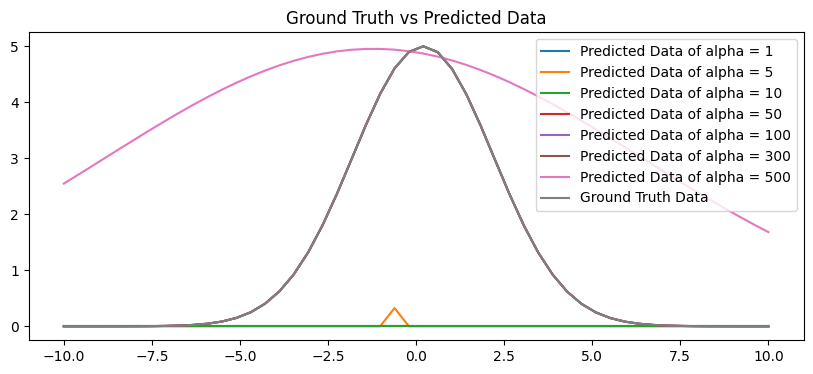

In [329]:

# alphas = [1, 2, 3, 4]
alphas = [1, 5, 10, 50, 100, 300, 500]
paramsArray1 = []

for i in range(len(alphas)):
    alpha1 = alphas[i]
    params1, _, losses = lm(x, y, iterations=400, lambda1=1, lr=alpha1)
    paramsArray1.append(params1)
    plt.plot(losses, label=str(alpha1))

plt.title("Learning Rate vs Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title("Ground Truth vs Predicted Data")
x1 = np.linspace(-10, 10)



for i in range(len(alphas)):
    params1 = paramsArray1[i]
    plt.plot(x1, f(x1, params1), label="Predicted Data of alpha = " + str(alphas[i]))
    
plt.plot(x1, f(x1, (a, m, s)), label="Ground Truth Data")
    

plt.legend()
plt.show()


#### Tolerance Plot

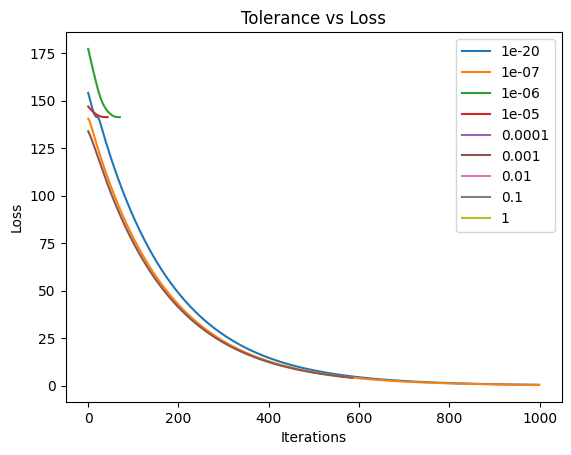

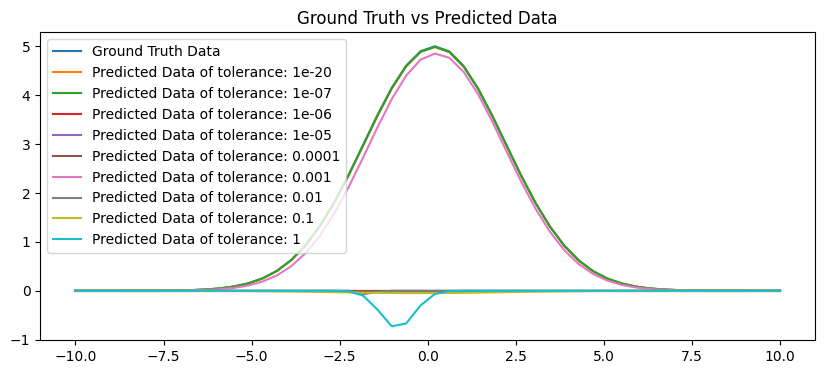

In [339]:

tolerances = [1e-20, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

paramsArray1 = []
for i in range(len(tolerances)):
    tolerance = tolerances[i]
    
    params1, _, losses = lm(x, y, iterations=1000, lambda1=1, lr=3, tolerance=tolerance)
    paramsArray1.append(params1)
    plt.plot(losses, label=str(tolerance))

plt.title("Tolerance vs Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title("Ground Truth vs Predicted Data")
x1 = np.linspace(-10, 10)
plt.plot(x1, f(x1, (a, m, s)), label="Ground Truth Data")

for i in range(len(tolerances)):
    params1 = paramsArray1[i]
    plt.plot(x1, f(x1, params1), label="Predicted Data of tolerance: " + str(tolerances[i]))
    


plt.legend()
plt.show()


In [336]:
print(paramsArray1)

[array([-1.53596663e-02,  1.78037674e+00, -3.66447791e-04]), array([-4.12691480e-03,  1.71257105e+00, -2.29241513e-04]), array([-0.42794024, -1.157399  , -0.03086592]), array([ 2.21215799, -1.74939624,  0.27987291]), array([10.28216502, -4.62977551, -1.24712357]), array([4.32906079, 0.19604283, 1.99981932]), array([-0.02060426,  1.7527009 , -0.01344574]), array([ 0.10488328, -0.50726293,  1.42998681]), array([-0.63637971,  1.02246088,  1.34093294])]


#### Observations

For Learning Rate (Alpha):

When the learning rate is set too high, the algorithm overshoots the minimum, causing oscillations or even divergence. This led to slower convergence or even failure to converge.
But, when the learning rate is too low, the algorithm takes small steps and converges very slowly. It gets stuck in local minima and struggles to escape them.

Using the above graphs, I find that the learning rate is optimal around ~ *100*

Number of Iterations:
If the number of iterations is set too low, the algorithm ends earlier, potentially before reaching an optimal solution. This resulted in worse parameter estimates. Increasing the number of iterations might have lead to better convergence, but after a certain point, additional iterations may not yield significant improvements and can lead to overfitting to the noise in the data.

Using the above graphs, I find that the number of iterations is optimal around ~ *400* and it usually converges earlier at 200


Tolerance :
A high tolerance value means the algorithm stops when the change in the cost function (or parameter values) is relatively small. This leads to premature convergence, potentially before reaching the true minimum. Hence, the result might not be accurate. Meanwhile, setting a low tolerance value leads to the algorithm running for a longer time. While this can potentially lead to a more accurate solution, it also leads to overfitting to the noise or numerical instability.

Using the above graphs, I find that the tolerance is optimal around ~ *1e-5*

In [ ]:
##############################################################################
# END OF YOUR CODE
##############################################################################

### SECTION 2: ICP

#### 2.1 Perform Procrustes alignmenton two point clouds with (given) known correspondences. 

Let X be your point cloud observed from the initial pose P1. You then transform it to a new pose P2. Now you wish to apply ICP to recover transformation between (X & P1) and (X & P2). 

Use toothless.ply point cloud and perform the alignment between the two point clouds using procrustes alignment. Your task is to write a function that takes two point clouds as input wherein the corresponding points between the two point clouds are located at the same index and returns the transformation matrix between them. Compute the alignment error after aligning the two point clouds.

**Use *root mean squared error (RSME)* as the alignment error metric.**

Make sure your code is modular as we will use this function in the next sub-part.

In [ ]:
##############################################################################
# TODO: Do tasks described in 2.1
##############################################################################

In [2]:
pcd = o3d.io.read_point_cloud("./data/toothless.ply")
pcd2 = o3d.io.read_point_cloud("./data/toothless.ply")
pcd3 = o3d.io.read_point_cloud("./data/toothless.ply")
rm = o3d.geometry.get_rotation_matrix_from_xyz((np.pi / 2, 0, np.pi/4))
pcd2.rotate(rm)
pcd2.translate((200, 300, -200))

coordinateFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200)
# o3d.visualization.draw_geometries([pcd, pcd2, coordinateFrame])

In [15]:
x = np.asarray(pcd.points)
print(x)

[[ -6.80940676  49.03529739 -98.90022278]
 [ -6.80940676  49.03529739 -98.90022278]
 [ -6.80940676  49.03529739 -98.90022278]
 ...
 [ -2.01986265  37.45590591 113.60958862]
 [ -2.02013779  37.45590591 113.6161499 ]
 [ -2.02155828  37.45590591 113.6500473 ]]


In [3]:
import numpy as np

def doICP(x, y):

    x0 = np.mean(x, axis=0)
    y0 = np.mean(y, axis=0)

    H = (x - x0).T @ (y - y0)
    
    U, D, Vt = np.linalg.svd(H)

    R = (Vt.T @ U.T)
    T = y0 - x0 @ R.T
    # T = y0 - x0
    
    return R, T

pcd = o3d.io.read_point_cloud("./data/toothless.ply")
pcd2 = o3d.io.read_point_cloud("./data/toothless.ply")

rm = o3d.geometry.get_rotation_matrix_from_zyx((np.pi / 2, 0, 0))

# pcd2.rotate(rm)                     # Arbitrary Transformation

pcd2.rotate(rm, center=(0,0,0))                     # Arbitrary Transformation
pcd2.translate((200, 300, -200))

x = np.asarray(pcd.points)
y = np.asarray(pcd2.points)
# print(x[0], "hsadfkad")
R, T = doICP(x, y)
# print(R.shape)
print(R)
pcd.rotate(R, center=(0, 0, 0))
print(T)

pcd.translate(T)

[[-1.68159514e-16 -1.00000000e+00 -1.54569607e-16]
 [ 1.00000000e+00  1.32394089e-16 -3.39057141e-16]
 [-2.49548854e-16 -2.26862294e-16  1.00000000e+00]]
[ 200.  300. -200.]


PointCloud with 232685 points.

In [23]:
o3d.visualization.draw_geometries([pcd, pcd2, coordinateFrame])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [ ]:
##############################################################################
# END OF YOUR CODE
##############################################################################

#### 2.2 Implement ICP algorithm with unknown correspondences.

Your task is to write a function that implements ICP and takes two point clouds as input wherein the correspondances are unknown. Visualize the pointclouds and plot their individual coordinate frames as you perform ICP over them. Compute the alignment error in each iteration.

In [5]:
##############################################################################
# TODO: Do tasks described in 2.2
##############################################################################


In [4]:

pcd = o3d.io.read_point_cloud("./data/toothless.ply")
pcd2 = o3d.io.read_point_cloud("./data/toothless.ply")
# pcd3 = o3d.io.read_point_cloud("./data/toothless.ply")
rm = o3d.geometry.get_rotation_matrix_from_xyz((np.pi / 2, 0, np.pi/4))
# rm = o3d.geometry.get_rotation_matrix_from_xyz((np.pi / 4, 0, 0))
pcd2.rotate(rm)
pcd2.translate((200, 300, -200))
coordinateFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200)

x = np.asarray(pcd.points)
y1 = np.asarray(pcd2.points)

colors1 = np.asarray(pcd2.colors)
randomIndexes = np.random.shuffle(np.arange(y1.shape[0]))


In [4]:
# y = y1[randomIndexes].squeeze()
# colors = colors1[randomIndexes].squeeze()
# pcd2.points = o3d.utility.Vector3dVector(y)
# pcd2.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd, pcd2, coordinateFrame])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


1   HIToolbox                           0x00000001a5d585c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x00000001a5d58188 _ZN15MenuBarInstance14EnableAutoShowEv + 60
3   HIToolbox                           0x00000001a5cfb310 SetMenuBarObscured + 372
4   HIToolbox                           0x00000001a5cfaee8 _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 172
5   HIToolbox                           0x00000001a5cf4fcc _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 296
6   HIToolbox                           0x00000001a5cbbcd0 _NotifyEventLoopObservers + 176
7   HIToolbox                           0x00000001a5cf496c AcquireEventFromQueue + 432
8   HIToolbox                           0x00000001a5ce3c84 ReceiveNextEventCommon + 320
9   HIToolbox                           0x00000001a5ce3b2c _BlockUntilNextEventMatchingListInModeWithFilter + 72
10  AppKit                              0x000000019f88984c _DPS

In [29]:
pcd = o3d.io.read_point_cloud("./data/toothless.ply")
pcd2 = o3d.io.read_point_cloud("./data/toothless.ply")
# pcd3 = o3d.io.read_point_cloud("./data/toothless.ply")
rm = o3d.geometry.get_rotation_matrix_from_xyz((0, np.pi / 4, np.pi / 2))
# rm = o3d.geometry.get_rotation_matrix_from_xyz((np.pi / 4, 0, 0))

def doICPUnknown(pcd, pcd2):

    pcd2points = np.asarray(pcd2.points)
    pcd2.points = o3d.utility.Vector3dVector(pcd2points)
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    vis.add_geometry(pcd)
    vis.add_geometry(pcd2)
    vis.add_geometry(coordinateFrame)

    iterations = 10
    for i in range(iterations):
        # R, T = doICP(x, y)
        # y = x @ R + T
        
        pcd2_kd_tree = o3d.geometry.KDTreeFlann(pcd)
        indexes = []
        for j in range(np.array(pcd.points).shape[0]):

            _, index, _ = pcd2_kd_tree.search_knn_vector_3d(np.asarray(pcd.points)[j], 1)
            # print("Input point: " + str((target_pc.points[j])) )

            # print("output point: " + str(index))
            indexes.append(index)
        
        # kdTreeParams = o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30)

        indexes = np.array(indexes)
        pcdWithIndexes = np.asarray(pcd2.points)[indexes].squeeze()
        
        # print(pcdWithIndexes.shape, target_pc.points.shape)
        
        # _, counts = np.unique(indexes, return_counts=True)
        # print("counts\n", counts.shape)
        
        # print("\ntarget2\n", pcdWithIndexes)
        
        R, T = doICP(np.asarray(pcd.points), pcdWithIndexes)
        if i != 9:
            R = R @ o3d.geometry.get_rotation_matrix_from_xyz(np.random.randn(3) * 0.1)
        pcdUpdated = np.asarray(pcd.points) @ R.T + T/2
        pcd.points = o3d.utility.Vector3dVector(pcdUpdated)
        
        # print("\n\nR\n", R)
        # print("\nT\n", T)
        
        vis.update_geometry(pcd)

        vis.poll_events()
        vis.update_renderer()
        
    vis.run()
    vis.destroy_window()

pcd2.rotate(rm)
pcd2.translate((200, 300, 200))
# pcd2points += np.random.randn(*pcd2points.shape) * 5

doICPUnknown(pcd, pcd2)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


1   HIToolbox                           0x00000001a5ce390c _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 44
2   HIToolbox                           0x00000001a5cfb214 SetMenuBarObscured + 120
3   HIToolbox                           0x00000001a5d02390 _ZN13HIApplication11FrontUILostEv + 44
4   HIToolbox                           0x00000001a5cfb04c _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 528
5   HIToolbox                           0x00000001a5cf4f70 _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 204
6   HIToolbox                           0x00000001a5cbbcd0 _NotifyEventLoopObservers + 176
7   HIToolbox                           0x00000001a5cf496c AcquireEventFromQueue + 432
8   HIToolbox                           0x00000001a5ce3c84 ReceiveNextEventCommon + 320
9   HIToolbox                           0x00000001a5ce3b2c _BlockUntilNextEventMatchingListInModeWithFilter + 72
10  AppKit                              0x000000019f88984c _DPSNextEv

In [27]:
o3d.visualization.draw_geometries([pcd, pcd2, coordinateFrame])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


#### Our algorithm converges in just one iteration, but for visualization purposes, we changed the expression slighlty.

In [ ]:
##############################################################################
# END OF YOUR CODE
##############################################################################
